In [24]:
!poetry add $(cat requirements.txt)

The following packages are already present in the pyproject.toml and will be skipped:

  - pandas
  - scikit-learn
  - python-binance
  - joblib
  - matplotlib
  - seaborn
  - requests
  - hmmlearn
  - ta
  - ipykernel
  - streamlit
  - plotly

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [ ]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import certifi
import time
from tqdm import tqdm
from joblib import Memory
from binance.client import Client
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from typing import List, Dict, Any
from datetime import timedelta
from dataclasses import dataclass
import glob
import os

from enum import Enum




## COLLECT DATA

### collect market data using binance api


In [25]:
client = Client()
exchange_info = client.get_exchange_info()

print(f"market info: {len(exchange_info['symbols'])}")


market info: 2878


### fetch curent market data for all trading pairs which would later be filtered

In [26]:
tickers = client.get_ticker()
tickers_df = pd.DataFrame(tickers).set_index('symbol')
tickers_df['quoteVolume'] = pd.to_numeric(tickers_df['quoteVolume'])

print(tickers_df.head(5))

         priceChange priceChangePercent weightedAvgPrice prevClosePrice  \
symbol                                                                    
ETHBTC   -0.00084000             -2.326       0.03525138     0.03611000   
LTCBTC   -0.00002900             -2.629       0.00108091     0.00110400   
BNBBTC    0.00013700              1.905       0.00723288     0.00719100   
NEOBTC   -0.00001000             -6.277       0.00015379     0.00015960   
QTUMETH  -0.00005600             -5.839       0.00094818     0.00096800   

          lastPrice      lastQty    bidPrice        bidQty    askPrice  \
symbol                                                                   
ETHBTC   0.03527000  26.40660000  0.03527000   31.33160000  0.03528000   
LTCBTC   0.00107400   0.10800000  0.00107400  198.97000000  0.00107500   
BNBBTC   0.00732900   0.04500000  0.00732900    0.41700000  0.00733000   
NEOBTC   0.00014930  10.12000000  0.00014920   10.12000000  0.00014930   
QTUMETH  0.00090300   1.700000

### setup cache and data directories for data collected

In [27]:
cache_dir = "./.cache"
data_dir = "./data/historical"
os.makedirs(cache_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

### setup cache and make requests in batches 
- to avoid rate limiting
- to speed up the process
- to avoid redundant requests


In [28]:
memory = Memory(cache_dir)

BATCH_SIZE = 30
SLEEP_TIME = 1


### filter market data
why these filters?
- MIN_VOLUME: to avoid data that is too low (50,000 USDT)
- MIN_MARKET_CAP: to avoid data that is too low (1,000,000 USDT)
- MAX_MARKET_CAP: to avoid data that is too high (100,000,000 USDT) as requested in the assigment
- KLINE_INTERVAL: to avoid data that is too low (15m)
- DAILY_BARS: to avoid data that is too low (96 bars)


In [29]:
class MarketFilters(Enum):
    MIN_MARKET_CAP: float = 1_000_000.00  # 1M USDT min
    MAX_MARKET_CAP: float = 100_000_000.00  # 100M USDT max
    MIN_VOLUME: float = 50_000.00  # Minimum daily volume
    KLINE_INTERVAL: str = "15m"  # For short-term analysis
    DAILY_BARS: int = 96  # 96 bars per day

### filter market data for USDT pairs and volume

### collect eligible symbols in batches
for each potential symbol:
- filter market cap
- collect data

In [30]:
url = "https://www.binance.com/bapi/apex/v1/friendly/apex/marketing/complianceSymbolList"

try:
    # get market caps
    response = requests.get(
                url, headers={"Accept-Encoding": "gzip"}, verify=certifi.where()
            )
    data = response.json()

    volumes = {  t["symbol"]: float(t["quoteVolume"]) for t in client.get_ticker() if t["symbol"].endswith("USDT") }

    # find valid coins
    small_coins = []
    for token in data.get("data", []):
        symbol = token.get("symbol", "")
        mcap = token.get("marketCap")
        vol = volumes.get(symbol, 0)

            # check market cap and volume criteria
        if (
            symbol.endswith("USDT")
                and mcap is not None
                and MarketFilters.MIN_MARKET_CAP.value  # Access the value
                <= float(mcap)
                <= MarketFilters.MAX_MARKET_CAP.value  # Access the value
                and vol >= MarketFilters.MIN_VOLUME.value  # Access the value
            ):
            small_coins.append(symbol)

        print(f"symbol: {symbol} mcap: {mcap} vol: {vol}")

    print(f"Found {len(small_coins)} small-cap coins")

except Exception as e:
            print(f"Error finding small caps: {str(e)}")

symbol: 1000CATUSDT mcap: 190633515.41652995 vol: 18026810.019571
symbol: 1000SATSUSDT mcap: 325674281.7320261 vol: 40339999.9106159
symbol: 1INCHUSDT mcap: 528265109.6625345 vol: 8761937.94535
symbol: 1MBABYDOGEUSDT mcap: 452832964.84150296 vol: 27632151.6176552
symbol: AAVEUSDT mcap: 4445467371.568393 vol: 72467057.86661
symbol: ACAUSDT mcap: 102564446.10762759 vol: 7240592.266331
symbol: ACEUSDT mcap: 84209619.69202442 vol: 4234613.6563
symbol: ACHUSDT mcap: 196191723.73910317 vol: 5741198.73591
symbol: ACMUSDT mcap: 9773878.10156774 vol: 907610.0149
symbol: ACTUSDT mcap: 305862977.434986 vol: 197347518.30281
symbol: ACXUSDT mcap: 161777586.88908133 vol: 11488009.01416
symbol: ADAUSDT mcap: 34568718291.0752 vol: 395874970.70531
symbol: ADXUSDT mcap: 28772042.85779162 vol: 4317699.0726
symbol: AERGOUSDT mcap: 57430835.20117745 vol: 2102803.5145
symbol: AEURUSDT mcap: 56703607.1192594 vol: 231802.61377
symbol: AEVOUSDT mcap: 306002452.13247555 vol: 11133721.473777
symbol: AGLDUSDT mca

### collect historical data on eligible symbols


#### time frame choice:
- the proposed 10m time frame for granularity could not be fetched since Binance API doesn't support it.
- the closest granularity that can be fetched is 15m
- data collected should be sufficient for the training of the model


In [31]:
def cached_get_klines(symbol, interval="15m"):
        """cache historical data requests"""
        @memory.cache
        def _get_klines(symbol=symbol, interval=interval):
            """get klines"""
            end_time = int(pd.Timestamp.now().timestamp() * 1000)
            start_time = int((pd.Timestamp.now() - pd.Timedelta(days=97)).timestamp() * 1000)
            all_klines = []
            current_start = start_time
            
            while current_start < end_time:
                klines = client.get_klines(
                    symbol=symbol,
                    interval=interval,
                    limit=1000,
                    startTime=current_start,
                    endTime=end_time
                )
                
                if not klines:
                    break
                    
                all_klines.extend(klines)
                
                current_start = klines[-1][0] + 1
                
            
            return all_klines

        return _get_klines

In [32]:
print("\nCollecting historical data...")
for i in range(0, len(small_coins), BATCH_SIZE):
    batch = small_coins[i : i + BATCH_SIZE]

    for symbol in tqdm(batch, desc=f"Batch {i//BATCH_SIZE + 1}"):
        try:
            # Get the cached function and call it to get the actual klines
            klines_func = cached_get_klines(
                    symbol=symbol, 
                    interval=MarketFilters.KLINE_INTERVAL.value
                )
            klines = klines_func()  # Call the function to get the actual data

            if len(klines) < MarketFilters.DAILY_BARS.value * 97:  # (training period + 1 week) * daily bars
                continue

            # Extract only OHLCV data from klines
            df = pd.DataFrame([
                [
                    k[0],  # timestamp
                    float(k[1]),  # open
                    float(k[2]),  # high
                    float(k[3]),  # low
                    float(k[4]),  # close
                    float(k[5])   # volume
                ] 
                for k in klines
            ], columns=["timestamp", "open", "high", "low", "close", "volume"])

            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
            df.set_index("timestamp", inplace=True)

            df.to_csv(f"data/historical/historical_{symbol}.csv")

        except Exception as e:
            print(f"Error collecting {symbol}: {e}")

        if i + BATCH_SIZE < len(small_coins):
            time.sleep(SLEEP_TIME)  # Avoid rate limits

Batch 4: 100%|██████████| 23/23 [00:08<00:00,  2.85it/s]


## FEATURE ENGINEERING

### feature params
- volatility_window: 10
- volume_ma_window: 7
- rsi_window: 12

In [33]:
@dataclass
class FeatureEngineer:
    def __init__(self):
        self.feature_columns = [
            'rsi', 'atr', 'obv', 'macd',
            'bb_position', 'volatility', 'momentum'
        ]

### calculate features

In [34]:
# RSI and ATR calculations
def calculate_rsi(self, data: pd.Series, period: int = 14) -> pd.Series:
    """Calculate the Relative Strength Index (RSI)."""
    delta = data.diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / (loss + 1e-8)
    return 100 - (100 / (1 + rs))

def calculate_atr(self, high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
    """Calculate the Average True Range (ATR)."""
    tr = pd.concat([
        high - low,
        abs(high - close.shift()),
        abs(low - close.shift())
    ], axis=1).max(axis=1)
    return tr.rolling(window=period).mean()

FeatureEngineer.calculate_rsi = calculate_rsi
FeatureEngineer.calculate_atr = calculate_atr

In [35]:
# Volume and Momentum indicators
def calculate_obv(self, close: pd.Series, volume: pd.Series) -> pd.Series:
    """Calculate the On-Balance Volume (OBV)."""
    obv = (np.sign(close.diff()) * volume).fillna(0).cumsum()
    return obv

def calculate_macd(self, data: pd.Series, short_period: int = 12, 
                  long_period: int = 26, signal_period: int = 9) -> pd.Series:
    """Calculate the Moving Average Convergence Divergence (MACD)."""
    short_ema = data.ewm(span=short_period, adjust=False).mean()
    long_ema = data.ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd - signal

FeatureEngineer.calculate_obv = calculate_obv
FeatureEngineer.calculate_macd = calculate_macd

In [54]:
# Main feature calculation method
def calculate_features(self, data: pd.DataFrame) -> pd.DataFrame:
    """Calculate features optimized for short-term HMM on small caps"""
    features = pd.DataFrame(index=data.index)
    
    # Core features for regime detection
    features['returns'] = np.log(data['close']).diff()
    features['volatility'] = (data['high'] - data['low']) / data['close']
    features['volatility'] = np.log1p(features['volatility'])
    
    # Oscillators with shorter periods for small caps
    features['rsi'] = self.calculate_rsi(data['close'], period=10)  # shorter period
    
    # Modified BB position with tighter bands for small caps
    bb_period = 15  # shorter period
    bb_std = 1.8    # tighter bands
    middle_band = data['close'].rolling(bb_period).mean()
    std_dev = data['close'].rolling(bb_period).std()
    upper_bb = middle_band + (bb_std * std_dev)
    lower_bb = middle_band - (bb_std * std_dev)
    features['bb_position'] = (data['close'] - lower_bb) / (upper_bb - lower_bb)
    
    # Short-term momentum (modified)
    features['momentum'] = (data['close'] / data['close'].shift(5) - 1).ewm(span=3).mean()
    
    # drop NaN values
    features = features.dropna()
    
    # Normalize features
    for col in features.columns:
        if col in ['rsi', 'bb_position']:  # Keep these in original scale
            continue
        elif col == 'volatility':
            features[col] = np.abs(features[col])
        elif col == 'returns':
            features[col] = features[col].clip(-0.15, 0.15)  # Wider clips for small caps
        else:
            max_abs_val = np.abs(features[col]).max()
            if max_abs_val > 0:
                features[col] = features[col] / max_abs_val
    
    return features

FeatureEngineer.calculate_features = calculate_features

In [55]:
# Train-test split functionality
def prepare_train_test(self, data: pd.DataFrame) -> tuple:
    """Prepare training and testing datasets with fixed 3-month training period"""
    features = self.calculate_features(data)
    
    train_size = 90 * 24 * 4  # 90 days * 24 hours * 4 (15-min intervals)

    
    if len(features) < train_size:
        raise ValueError(f"Not enough data. Need at least {train_size} rows, but got {len(features)}")
    
    train_data = features[:train_size]
    test_data = features[train_size:]
    
    print(f"\nData Split Info:")
    print(f"Training period: {train_data.index[0]} to {train_data.index[-1]}")
    print(f"Testing period: {test_data.index[0]} to {test_data.index[-1]}")
    print(f"Training samples: {len(train_data)}")
    print(f"Testing samples: {len(test_data)}")
    
    return train_data, test_data

FeatureEngineer.prepare_train_test = prepare_train_test

In [56]:
## TRAINING DATA

# let's set up our training window (last 3 months)
def prepare_training_data(df: pd.DataFrame, training_days: int = 90) -> pd.DataFrame:
    """prepare training data with specified window"""
    end_date = df.index[-1]
    start_date = end_date - timedelta(days=training_days)
    return df[start_date:end_date]

In [57]:
# Create an instance and test
engineer = FeatureEngineer()
print("Available features:", engineer.feature_columns)

Available features: ['rsi', 'atr', 'obv', 'macd', 'bb_position', 'volatility', 'momentum']


### visualize feature selection
sample analysis on the first symbol

In [40]:
# Process historical data and prepare train-test splits

feature_dfs = {}
train_test_splits = {}

# Read all historical CSV files
historical_files = glob.glob("data/historical/historical_*.csv")

for file_path in historical_files:
    # Extract symbol from filename
    symbol = os.path.basename(file_path).replace("historical_", "").replace(".csv", "")
    
    # Read historical data
    df = pd.read_csv(file_path, index_col='timestamp', parse_dates=True)
    
    try:
        # Calculate features and store them
        features = engineer.calculate_features(df)
        feature_dfs[symbol] = features
        
        # Prepare train-test split
        train_data, test_data = engineer.prepare_train_test(df)
        train_test_splits[symbol] = {
            'train': train_data,
            'test': test_data
        }
        
    except Exception as e:
        print(f"Error processing {symbol}: {e}")

print(f"Processed features and splits for {len(feature_dfs)} symbols")


Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2

### correlation heatmap
initially, we will look at the correlation between features for a single symbol.

thoughts on feature selection:
- returns and volatility show no correlation
- volume intensity and returns are weakly correlated
- volume intensity and volatility are weakly correlated
- rsi and returns show relatively moderate correlation
  
it appears that the features set is well balanced and captures the price movement, volatility, volume, and momentum.


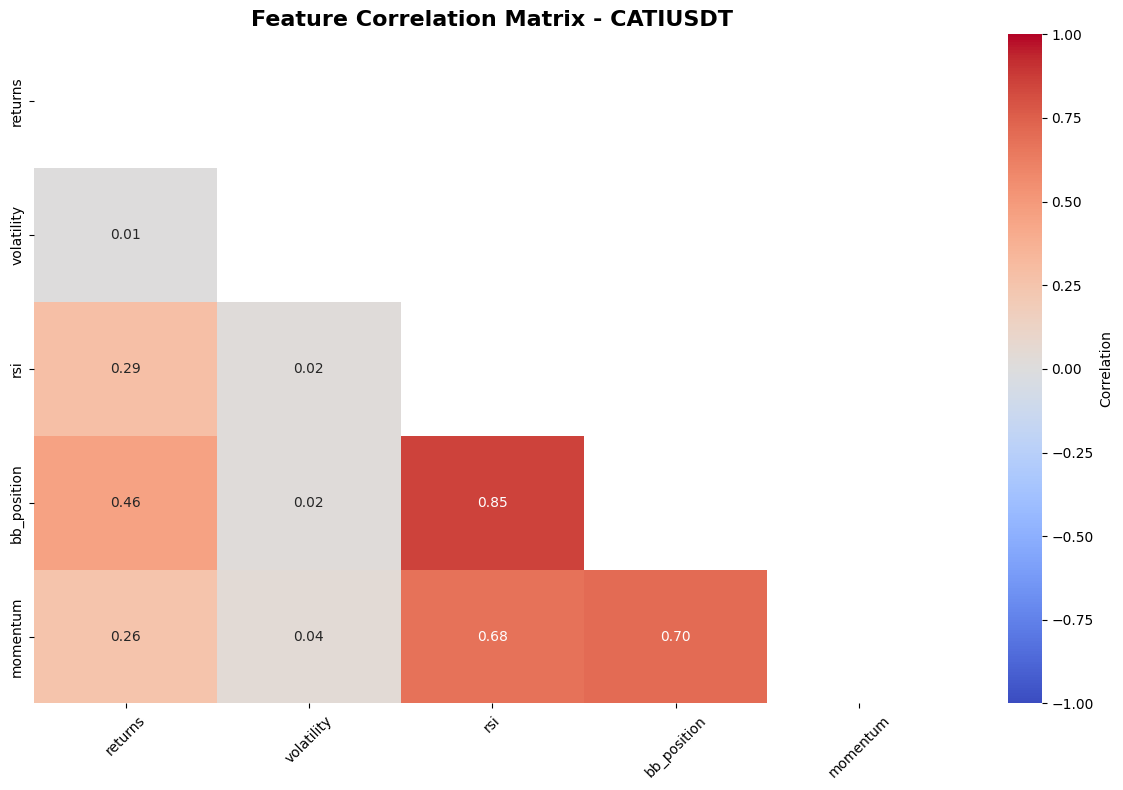

In [41]:
symbol = list(feature_dfs.keys())[0]  # first symbol
features = feature_dfs[symbol]

# correlation Heatmap
plt.figure(figsize=(12, 8))

corr_matrix = features.corr()

# craete heatmap
sns.heatmap(
    corr_matrix,
    annot=True,  # annotate with corr valuse
    fmt=".2f",   # limit to 2 decimal points
    mask=np.triu(np.ones_like(corr_matrix, dtype=bool)),  # show lower triangle
    cmap="coolwarm",  
    vmin=-1, vmax=1,  # correlation range
    center=0,
    cbar_kws={'label': 'Correlation'}  # add labels to color bar
)

plt.title(f'Feature Correlation Matrix - {symbol}', fontsize=16, weight='bold')
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### feature distributions
thoughts on feature distributions:
- returns are normally distributed
- volatility is skewed to the right
- volume intensity is skewed to the right
- rsi is almost normally distributed. i mean its around 49.5 so that's good not bad


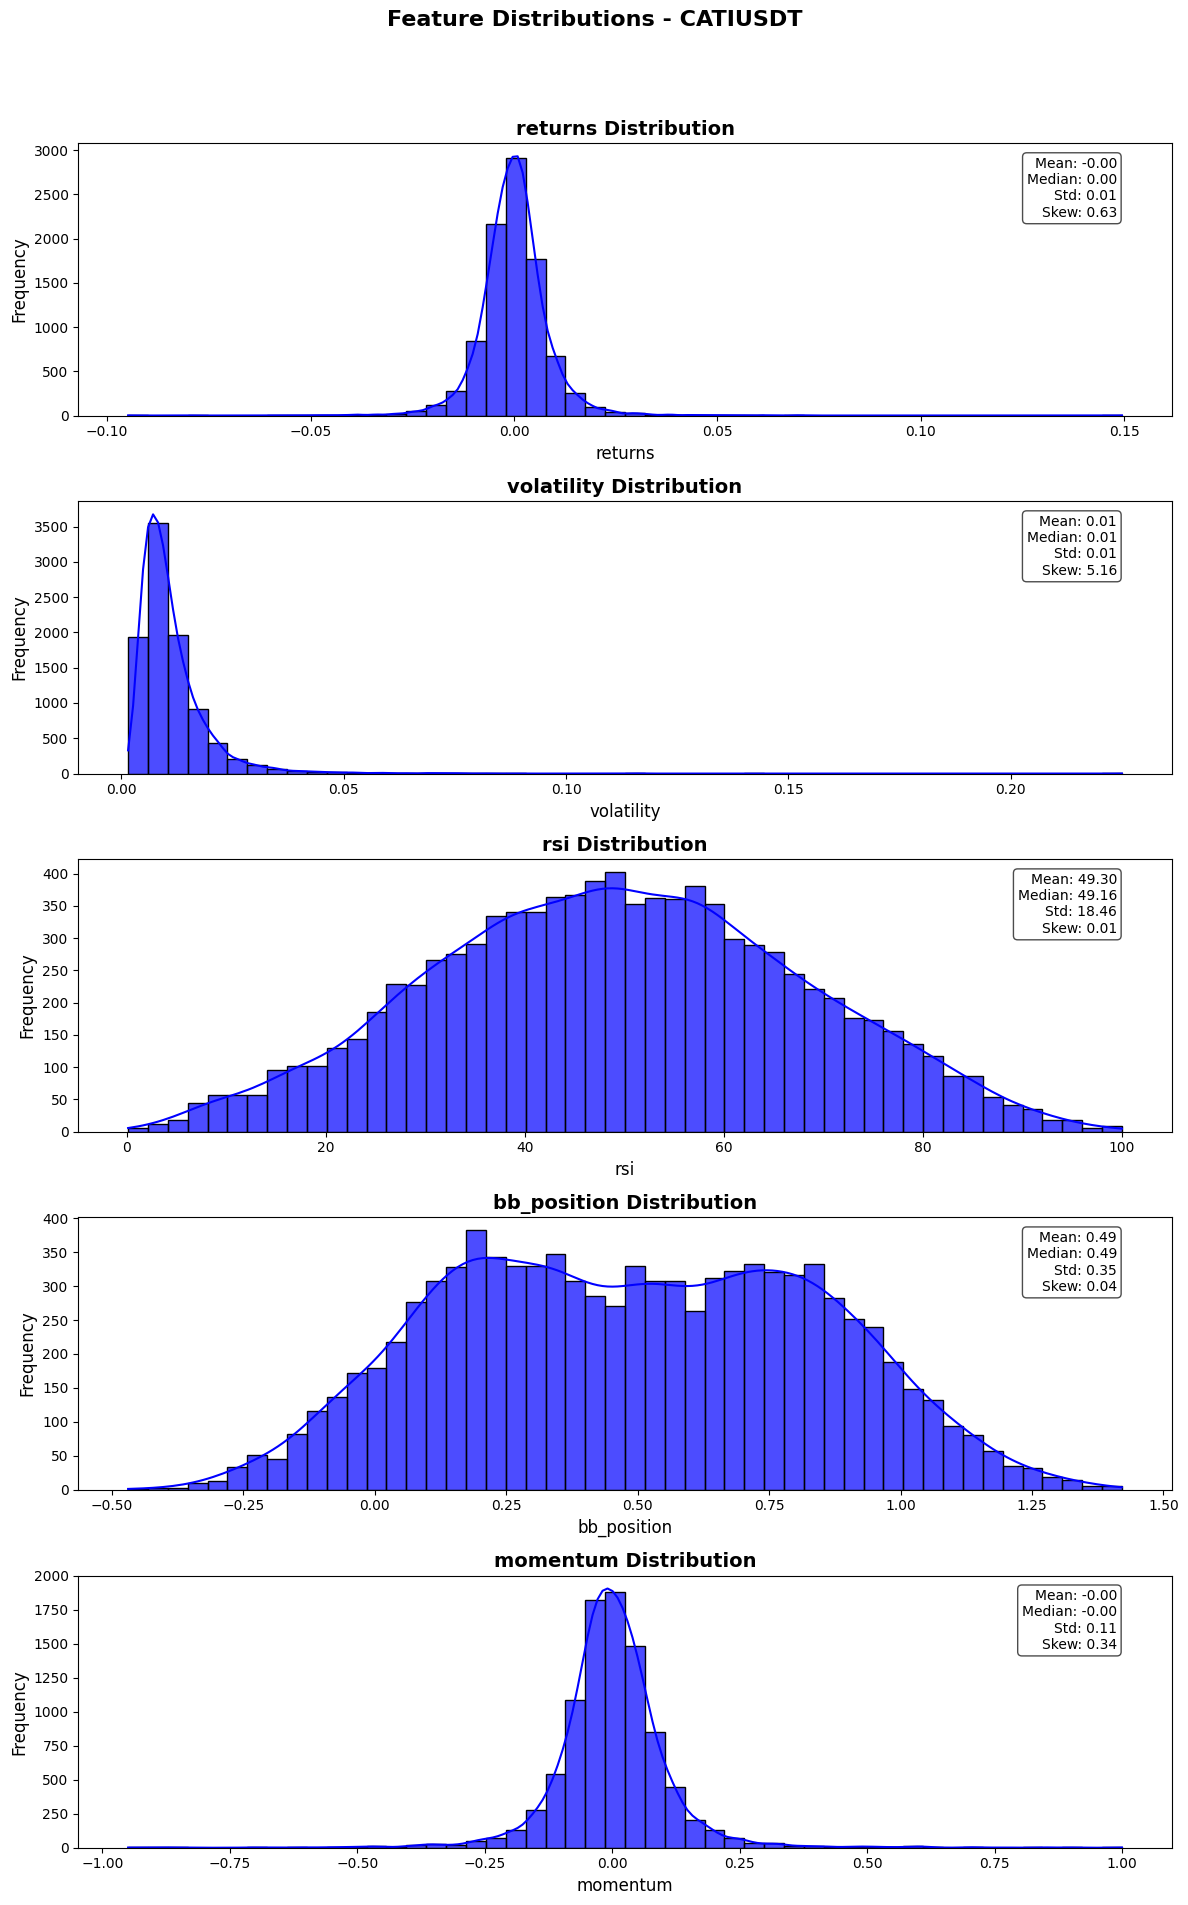

In [42]:
num_features = features.select_dtypes(include=np.number).columns  # select numerical features
features_subset = features[num_features]  # subset of numerical features

fig, axes = plt.subplots(len(features_subset.columns), 1, figsize=(12, len(features_subset.columns) * 4))

for i, feature in enumerate(features_subset.columns):
    ax = axes[i]
    sns.histplot(features_subset[feature], bins=50, kde=True, ax=ax, color='blue', alpha=0.7)
    ax.set_title(f'{feature} Distribution', fontsize=14, weight='bold')
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

    # add a text box with statistics
    mean = features_subset[feature].mean()
    median = features_subset[feature].median()
    std = features_subset[feature].std()
    skew = features_subset[feature].skew()
    ax.text(0.95, 0.95,
            f"Mean: {mean:.2f}\nMedian: {median:.2f}\nStd: {std:.2f}\nSkew: {skew:.2f}",
            transform=ax.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

plt.suptitle(f'Feature Distributions - {symbol}', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # should be enough space for suptitle
plt.show()

In [43]:
# Show what features we have for one symbol
symbol = list(feature_dfs.keys())[0]
print(f"Example features for {symbol}:")
print("\nFeature DataFrame shape:", feature_dfs[symbol].shape)
print("\nFeature columns:")
print(feature_dfs[symbol].head())

Example features for CATIUSDT:

Feature DataFrame shape: (9298, 5)

Feature columns:
                      returns  volatility        rsi  bb_position  momentum
timestamp                                                                  
2024-10-03 15:00:00 -0.011389    0.020264  43.165364    -0.043460 -0.154457
2024-10-03 15:15:00 -0.008183    0.025539  36.573989    -0.066037 -0.234226
2024-10-03 15:30:00  0.002661    0.018162  41.463314     0.069849 -0.220754
2024-10-03 15:45:00  0.037814    0.042226  51.612799     0.732883 -0.103098
2024-10-03 16:00:00 -0.008137    0.015481  43.495847     0.580108 -0.007870


## TRAINING DATA

In [44]:
# let's set up our training window (last 3 months)
def prepare_training_data(df: pd.DataFrame, training_days: int = 90) -> pd.DataFrame:
    """prepare training data with specified window"""
    end_date = df.index[-1]
    start_date = end_date - timedelta(days=training_days)
    return df[start_date:end_date]

In [101]:
# training data for one symbol
training_data = prepare_training_data(feature_dfs[symbol])
print(f"\ntraining data for {symbol}:")
print("period:", training_data.index[1], "to", training_data.index[-1])
print("observations:", len(training_data))


training data for CATIUSDT:
period: 2024-10-10 11:30:00 to 2025-01-08 11:15:00
observations: 8641


In [102]:
@dataclass
class HMMConfig:
    n_states: int = 3           # no. of hidden states
    n_iter: int = 150           # maximum iterations for training
    tol: float = 1e-5           # convergence tolerance
    random_seed: int = 42 
    init_params: str = "kmeans"

In [103]:
config = HMMConfig()

class HMMMarketCycle:
    """Gaussian Hidden Markov Model (HMM) for market cycle detection."""

    def __init__(self, config: HMMConfig, feature_columns: List[str]):
        self.config = config
        self.feature_columns = feature_columns
        self.model = hmm.GaussianHMM(
            n_components=config.n_states,
            covariance_type="diag",
            n_iter=config.n_iter,
            tol=config.tol,
            random_state=config.random_seed,
            init_params=config.init_params,     # kmeans is a good starting point, update later !!
        )
        self.scaler = StandardScaler()
        self.trained = False
        self.state_labels = []

In [104]:
def _validate_features(self, features: pd.DataFrame) -> None:
    """ensure the required features are present in the DataFrame"""
    missing_features = set(self.feature_columns) - set(features.columns)
    if missing_features:
        raise ValueError(f"Missing required features: {missing_features}")

def _prepare_features(self, features: pd.DataFrame) -> np.ndarray:
    """validate and scale the feature data"""
    self._validate_features(features)
    X = features[self.feature_columns].values
    return self.scaler.fit_transform(X) if not self.trained else self.scaler.transform(X)

In [105]:
# Add methods to class
HMMMarketCycle._validate_features = _validate_features
HMMMarketCycle._prepare_features = _prepare_features

In [106]:
# note to self: before making predictions, i check if the model is trained. if it's not, raise an error.
# after ensuring the model is ready, i prepare the features and compute the state probabilities using `predict_proba()`.
# then, i predict the most likely state for each data point using `predict()`.
# i want the results to be in a DataFrame for easy access, where each row corresponds to the data points
# and each column holds the probability for a given state (e.g., bull, bear, neutral).
def predict(self, data: pd.DataFrame) -> pd.DataFrame:
    """predict the hidden states for the given data and return a DataFrame with state probabilities."""
    if not self.trained:
        raise RuntimeError("train the model first.")
    X = self._prepare_features(data)
    state_probs = self.model.predict_proba(X)
    states = self.model.predict(X)

    results = pd.DataFrame(state_probs, columns=[f"{label}_prob" for label in self.state_labels], index=data.index)
    results["state"] = [self.state_labels[state] for state in states]
    return results

HMMMarketCycle.predict = predict

In [107]:
# note to self: Here, I’m classifying the states based on their mean values of returns and volatility.
# the idea is to classify states into 'bull', 'bear', or 'neutral' based on these two features.
# i use the "returns" and "volatility" features to make the classification more intuitive:
# - Bull: High returns, low volatility
# - Bear: Low returns, high volatility
# - Neutral: Everything else (default case)
# first, get the predicted states, then compute the mean feature values for each state.
# use the median volatility to separate the bull and bear states from neutral ones.
def _assign_state_labels(self, X: np.ndarray) -> List[str]:
    """Assign labels to states based on their features."""
    states = self.model.predict(X)
    state_means = np.array([X[states == i].mean(axis=0) for i in range(self.config.n_states)])
    
    # Get indices for returns and volatility
    returns_idx = self.feature_columns.index("returns")
    vol_idx = self.feature_columns.index("volatility")
    
    # Calculate median values for classification
    median_returns = np.median(state_means[:, returns_idx])
    median_volatility = np.median(state_means[:, vol_idx])
    
    labels = []
    for i in range(self.config.n_states):
        returns = state_means[i, returns_idx]
        volatility = state_means[i, vol_idx]
        
        # More aggressive classification
        if returns > 0:
            labels.append("bull")
        elif returns < 0:
            labels.append("bear")
        else:
            labels.append("neutral")
    
    print("State Classification:")
    for i, label in enumerate(labels):
        print(f"State {i}: {label} (Returns: {returns:.6f}, Volatility: {volatility:.6f})")
    
    return labels

# Update the method in your model
HMMMarketCycle._assign_state_labels = _assign_state_labels

In [108]:
# note to self: AIC balances model fit and complexity.
# start by calculating the number of parameters (n_params), which depends on the number of states
# and the features involved. then, plug into the formula
# keep in mind, AIC doesn't penalize large datasets as much, so it's good for comparison.
def _calculate_aic(self, X: np.ndarray) -> float:
    """calculate the Akaike Information Criterion (AIC)."""
    n_params = self.config.n_states * (len(self.feature_columns) + self.config.n_states - 1)
    return -2 * self.model.score(X) + 2 * n_params


# useful for avoiding overfitting on large datasets since it penalizes complex models more heavily.
# like before, calculate n_params and substitute into the formula.
def _calculate_bic(self, X: np.ndarray) -> float:
    """calculate the Bayesian Information Criterion (BIC)."""
    n_params = self.config.n_states * (len(self.feature_columns) + self.config.n_states - 1)
    return -2 * self.model.score(X) + n_params * np.log(len(X))

HMMMarketCycle._calculate_aic = _calculate_aic
HMMMarketCycle._calculate_bic = _calculate_bic

In [109]:
def train(self, data: pd.DataFrame) -> Dict[str, Any]:
    """train the HMM using the baum-welch algorithm and return model performance metrics"""
    X = self._prepare_features(data)
    self.model.fit(X)
    self.trained = True
    self.state_labels = self._assign_state_labels(X)

    metrics = {
        "log_likelihood": self.model.score(X),
        "n_iter": self.model.monitor_.iter,
        "converged": self.model.monitor_.converged,
        "aic": self._calculate_aic(X),
        "bic": self._calculate_bic(X),
    }
    return metrics

HMMMarketCycle.train = train

In [120]:
# Cell 1: Setup Configuration
@dataclass
class TradingConfig:
    initial_balance: float = 10000.0
    trading_fee: float = 0.001
    position_size: float = 0.95
    n_iter: int = 150

trading_config = TradingConfig()

In [127]:
from pprint import pprint


pprint(list((i, x) for i, x in enumerate(feature_dfs.keys())))




[(0, 'CATIUSDT'),
 (1, 'FIROUSDT'),
 (2, 'GTCUSDT'),
 (3, 'CITYUSDT'),
 (4, 'BARUSDT'),
 (5, 'ALCXUSDT'),
 (6, 'ACEUSDT'),
 (7, 'PDAUSDT'),
 (8, 'BADGERUSDT'),
 (9, 'MBOXUSDT'),
 (10, 'REZUSDT'),
 (11, 'WANUSDT'),
 (12, 'VIBUSDT'),
 (13, 'BIFIUSDT'),
 (14, 'GNSUSDT'),
 (15, 'JUVUSDT'),
 (16, 'ARDRUSDT'),
 (17, 'PSGUSDT'),
 (18, 'LEVERUSDT'),
 (19, 'ASTUSDT'),
 (20, 'LISTAUSDT'),
 (21, 'BETAUSDT'),
 (22, 'DIAUSDT'),
 (23, 'FIOUSDT'),
 (24, 'VICUSDT'),
 (25, 'PHBUSDT'),
 (26, 'PERPUSDT'),
 (27, 'ACMUSDT'),
 (28, 'FISUSDT'),
 (29, 'DEGOUSDT'),
 (30, 'CTXCUSDT'),
 (31, 'ERNUSDT'),
 (32, 'HIGHUSDT'),
 (33, 'UFTUSDT'),
 (34, 'PORTOUSDT'),
 (35, 'ATAUSDT'),
 (36, 'CREAMUSDT'),
 (37, 'UTKUSDT'),
 (38, 'AMBUSDT'),
 (39, 'ALICEUSDT'),
 (40, 'MBLUSDT'),
 (41, 'ADXUSDT'),
 (42, 'USDPUSDT'),
 (43, 'DATAUSDT'),
 (44, 'NKNUSDT'),
 (45, 'MAVUSDT'),
 (46, 'AEURUSDT'),
 (47, 'LINAUSDT'),
 (48, 'REQUSDT'),
 (49, 'GHSTUSDT'),
 (50, 'BNTUSDT'),
 (51, 'PROSUSDT'),
 (52, 'STMXUSDT'),
 (53, 'OGNUSDT'),
 (54, 

In [135]:
# Cell 2: Get the first symbol and data

symbol = list(feature_dfs.keys())[11]
train_data = train_test_splits[symbol]['train']
test_data = train_test_splits[symbol]['test']

# Load price data
price_data = pd.read_csv(f"data/historical/historical_{symbol}.csv", 
                        index_col='timestamp', 
                        parse_dates=True)

print("Symbol:", symbol)
print("Test data shape:", test_data.shape)
print("Price data shape:", price_data.shape)

Symbol: WANUSDT
Test data shape: (658, 5)
Price data shape: (9312, 5)


In [136]:
# Cell 3: Train model and get predictions
model_config = HMMConfig()
model = HMMMarketCycle(model_config, ['returns', 'volatility', 'rsi', 'momentum', 'bb_position'])
model.train(train_data)
predictions = model.predict(test_data)

print("Predictions shape:", predictions.shape)
print("\nState distribution:")
print(predictions['state'].value_counts())

State Classification:
State 0: bull (Returns: -0.348162, Volatility: 1.507265)
State 1: bear (Returns: -0.348162, Volatility: 1.507265)
State 2: bear (Returns: -0.348162, Volatility: 1.507265)
Predictions shape: (658, 4)

State distribution:
state
bear    337
bull    321
Name: count, dtype: int64


In [137]:
# Cell 3.5: Check predictions
print("Prediction states distribution:")
print(predictions['state'].value_counts())
print("\nFirst few predictions:")
print(predictions.head())
print("\nFirst few price data points:")
print(price_data.head())
print("\nTime ranges:")
print("Predictions:", predictions.index.min(), "to", predictions.index.max())
print("Price data:", price_data.index.min(), "to", price_data.index.max())

Prediction states distribution:
state
bear    337
bull    321
Name: count, dtype: int64

First few predictions:
                     bull_prob     bear_prob  bear_prob state
timestamp                                                    
2025-01-01 15:15:00   0.000000  0.000000e+00   1.000000  bear
2025-01-01 15:30:00   0.995169  4.965287e-06   0.004826  bull
2025-01-01 15:45:00   0.999990  3.706485e-10   0.000010  bull
2025-01-01 16:00:00   0.999998  7.100884e-08   0.000002  bull
2025-01-01 16:15:00   0.999997  3.248080e-09   0.000003  bull

First few price data points:
                       open    high     low   close   volume
timestamp                                                   
2024-10-03 11:45:00  0.1609  0.1609  0.1605  0.1607  11560.0
2024-10-03 12:00:00  0.1607  0.1607  0.1592  0.1598  18977.0
2024-10-03 12:15:00  0.1598  0.1603  0.1597  0.1601   8161.0
2024-10-03 12:30:00  0.1600  0.1609  0.1599  0.1601  10039.0
2024-10-03 12:45:00  0.1602  0.1607  0.1601  0.1603  10394

In [138]:
portfolio_values = []
trade_history = []
current_balance = trading_config.initial_balance
units = 0
in_position = False

# Ensure price data and predictions are aligned
test_period_prices = price_data.loc[predictions.index]

print("Debug Info:")
print(f"Predictions length: {len(predictions)}")
print(f"Unique states: {predictions['state'].unique()}")
print(f"State counts:\n{predictions['state'].value_counts()}")
print(f"First few predictions:\n{predictions['state'].head()}")
print(f"First few prices:\n{test_period_prices['close'].head()}")

# Loop through each prediction
for i in range(len(predictions)):
    date = predictions.index[i]
    try:
        price = test_period_prices.loc[date, 'close']
        state = predictions['state'].iloc[i]
        
        # Debug print for first few iterations
        if i < 5:
            print(f"\nIteration {i}:")
            print(f"Date: {date}")
            print(f"Price: {price}")
            print(f"State: {state}")
            print(f"Current position: {'Yes' if in_position else 'No'}")
        
        # Trading logic
        if state == 'bull' and not in_position:
            # Buy
            position_size = current_balance * trading_config.position_size
            units = position_size / price
            fee = position_size * trading_config.trading_fee
            current_balance -= (position_size + fee)
            in_position = True
            trade_history.append({
                'date': date,
                'action': 'buy',
                'price': price,
                'units': units,
                'fee': fee,
                'balance': current_balance
            })
            
            print(f"\nBUY Signal:")
            print(f"Units bought: {units}")
            print(f"Price: {price}")
            print(f"New balance: {current_balance}")
            
        elif state == 'bear' and in_position:
            # Sell
            position_value = units * price
            fee = position_value * trading_config.trading_fee
            current_balance += (position_value - fee)
            trade_history.append({
                'date': date,
                'action': 'sell',
                'price': price,
                'units': units,
                'fee': fee,
                'balance': current_balance
            })
            units = 0
            in_position = False
            
            print(f"\nSELL Signal:")
            print(f"Units sold: {units}")
            print(f"Price: {price}")
            print(f"New balance: {current_balance}")
        
        # Calculate portfolio value
        portfolio_value = current_balance + (units * price) if in_position else current_balance
        portfolio_values.append(portfolio_value)
        
    except KeyError as e:
        print(f"Error at date {date}: {e}")
        continue

# Create results dictionary
results = {
    'final_balance': current_balance,
    'portfolio_values': pd.Series(portfolio_values, index=predictions.index),
    'trade_history': pd.DataFrame(trade_history)
}

print("\nTrading Summary:")
print(f"Number of trades: {len(trade_history)}")
print(f"Final balance: ${results['final_balance']:.2f}")

if len(trade_history) > 0:
    trade_df = pd.DataFrame(trade_history)
    print("\nFirst few trades:")
    print(trade_df.head())
    print("\nLast few trades:")
    print(trade_df.tail())

Debug Info:
Predictions length: 658
Unique states: ['bear' 'bull']
State counts:
state
bear    337
bull    321
Name: count, dtype: int64
First few predictions:
timestamp
2025-01-01 15:15:00    bear
2025-01-01 15:30:00    bull
2025-01-01 15:45:00    bull
2025-01-01 16:00:00    bull
2025-01-01 16:15:00    bull
Name: state, dtype: object
First few prices:
timestamp
2025-01-01 15:15:00    0.2148
2025-01-01 15:30:00    0.2164
2025-01-01 15:45:00    0.2173
2025-01-01 16:00:00    0.2167
2025-01-01 16:15:00    0.2175
Name: close, dtype: float64

Iteration 0:
Date: 2025-01-01 15:15:00
Price: 0.2148
State: bear
Current position: No

Iteration 1:
Date: 2025-01-01 15:30:00
Price: 0.2164
State: bull
Current position: No

BUY Signal:
Units bought: 43900.184842883544
Price: 0.2164
New balance: 490.5

Iteration 2:
Date: 2025-01-01 15:45:00
Price: 0.2173
State: bull
Current position: Yes

Iteration 3:
Date: 2025-01-01 16:00:00
Price: 0.2167
State: bull
Current position: Yes

Iteration 4:
Date: 2025-01-

In [139]:
# Calculate buy & hold performance
buy_hold_values = price_data.loc[test_data.index, 'close'] * (trading_config.initial_balance / price_data.loc[test_data.index[0], 'close'])

# Calculate returns and metrics
portfolio_returns = results['portfolio_values'].pct_change().dropna()
benchmark_returns = buy_hold_values.pct_change().dropna()

# Calculate cumulative returns
portfolio_cum_returns = (1 + portfolio_returns).cumprod()
benchmark_cum_returns = (1 + benchmark_returns).cumprod()

# Calculate drawdowns
portfolio_drawdown = (portfolio_cum_returns - portfolio_cum_returns.cummax()) / portfolio_cum_returns.cummax()
benchmark_drawdown = (benchmark_cum_returns - benchmark_cum_returns.cummax()) / benchmark_cum_returns.cummax()

# Calculate Sharpe ratios (assuming 2% risk-free rate)
risk_free_rate = 0.02
portfolio_sharpe = np.sqrt(252) * (portfolio_returns.mean() - risk_free_rate/252) / portfolio_returns.std()
benchmark_sharpe = np.sqrt(252) * (benchmark_returns.mean() - risk_free_rate/252) / benchmark_returns.std()

metrics = {
    'Portfolio': {
        'Total Return': (results['portfolio_values'].iloc[-1] / results['portfolio_values'].iloc[0] - 1) * 100,
        'Sharpe Ratio': portfolio_sharpe,
        'Max Drawdown': portfolio_drawdown.min() * 100,
        'Daily Volatility': portfolio_returns.std() * 100
    },
    'Benchmark': {
        'Total Return': (buy_hold_values.iloc[-1] / buy_hold_values.iloc[0] - 1) * 100,
        'Sharpe Ratio': benchmark_sharpe,
        'Max Drawdown': benchmark_drawdown.min() * 100,
        'Daily Volatility': benchmark_returns.std() * 100
    }
}

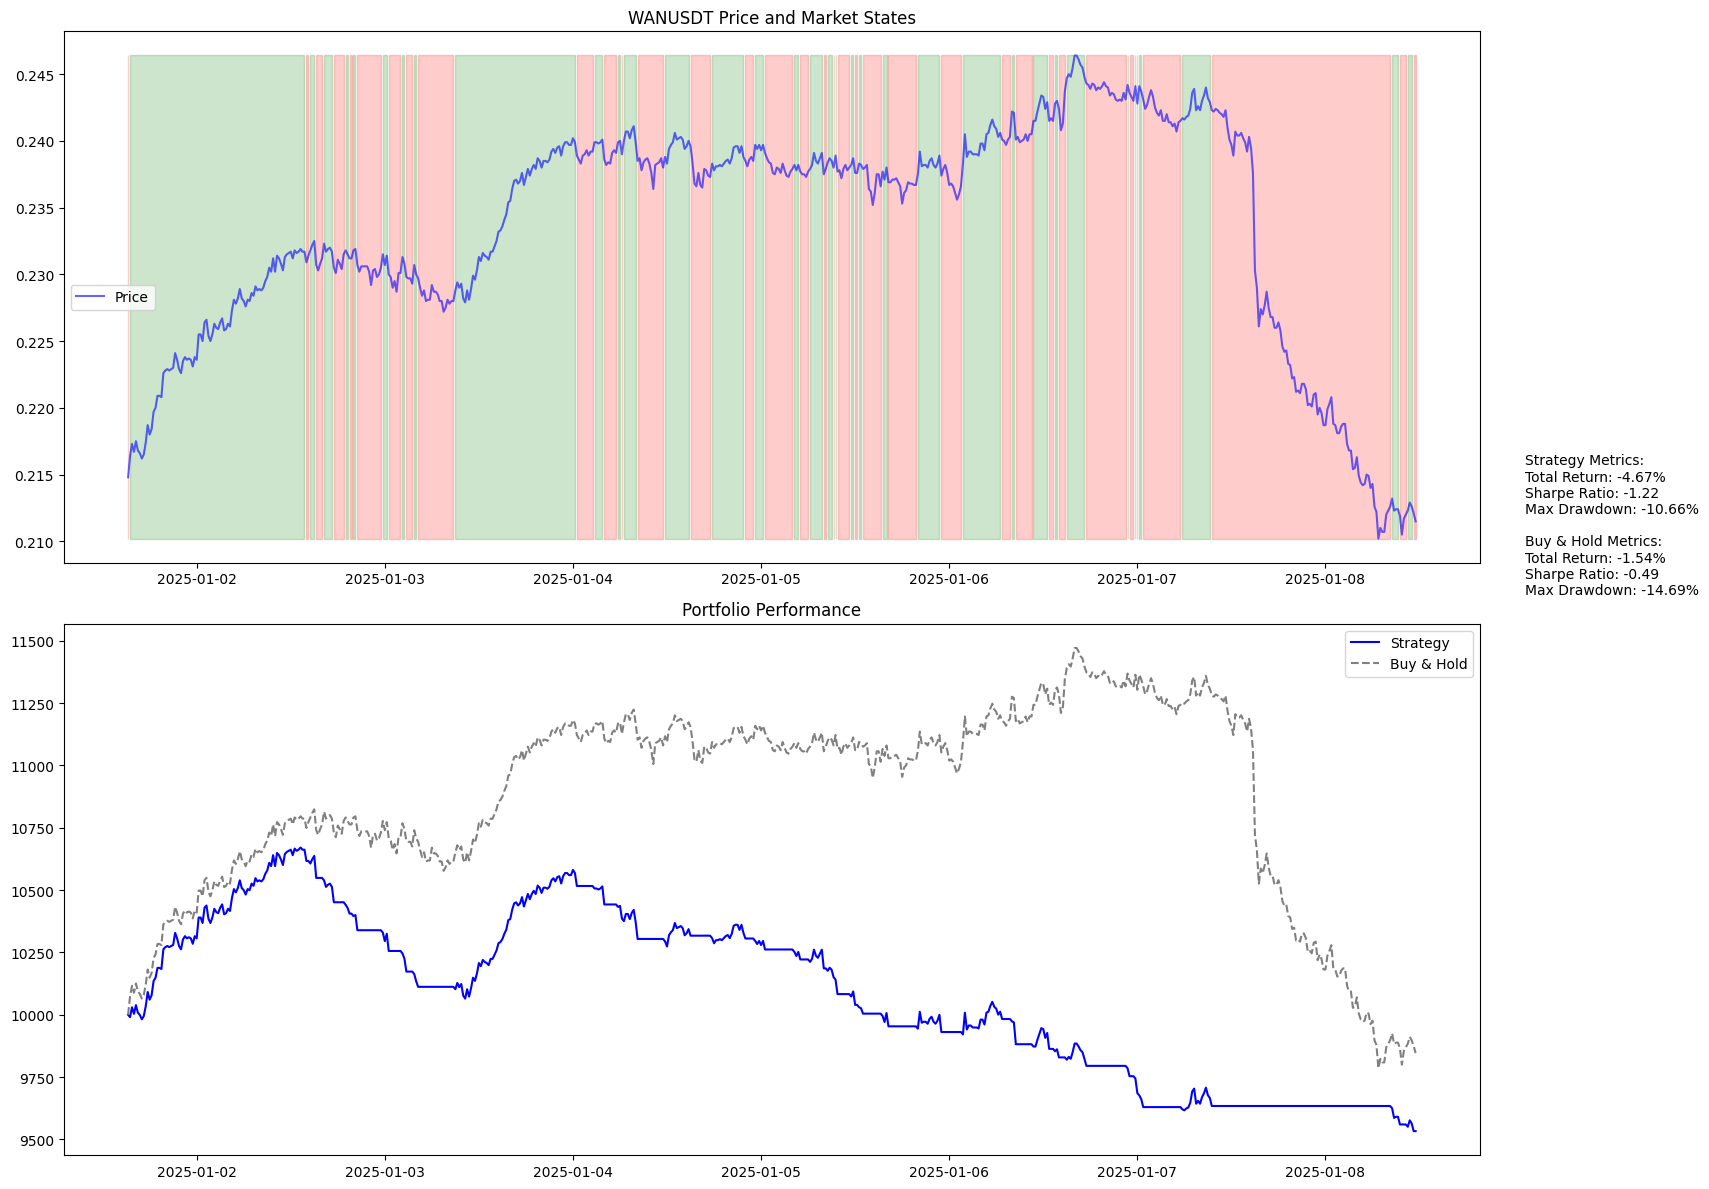


Detailed Performance Metrics:

Portfolio Metrics:
Total Return: -4.67
Sharpe Ratio: -1.22
Max Drawdown: -10.66
Daily Volatility: 0.20

Benchmark Metrics:
Total Return: -1.54
Sharpe Ratio: -0.49
Max Drawdown: -14.69
Daily Volatility: 0.32


In [140]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Price and States
ax1.plot(price_data.loc[test_data.index, 'close'], label='Price', color='blue', alpha=0.6)

# Color states
for state in ['bull', 'bear', 'neutral']:
    mask = predictions['state'] == state
    color = {'bull': 'green', 'bear': 'red', 'neutral': 'gray'}[state]
    ax1.fill_between(test_data.index, 
                     price_data.loc[test_data.index, 'close'].min(), 
                     price_data.loc[test_data.index, 'close'].max(),
                     where=mask, color=color, alpha=0.2)

ax1.set_title(f'{symbol} Price and Market States')
ax1.legend()

# Plot 2: Portfolio Performance
ax2.plot(results['portfolio_values'].index, results['portfolio_values'], 
         label='Strategy', color='blue')
ax2.plot(buy_hold_values.index, buy_hold_values, 
         label='Buy & Hold', color='gray', linestyle='--')
ax2.set_title('Portfolio Performance')
ax2.legend()

# Add metrics as text
metrics_text = (
    f"Strategy Metrics:\n"
    f"Total Return: {metrics['Portfolio']['Total Return']:.2f}%\n"
    f"Sharpe Ratio: {metrics['Portfolio']['Sharpe Ratio']:.2f}\n"
    f"Max Drawdown: {metrics['Portfolio']['Max Drawdown']:.2f}%\n\n"
    f"Buy & Hold Metrics:\n"
    f"Total Return: {metrics['Benchmark']['Total Return']:.2f}%\n"
    f"Sharpe Ratio: {metrics['Benchmark']['Sharpe Ratio']:.2f}\n"
    f"Max Drawdown: {metrics['Benchmark']['Max Drawdown']:.2f}%"
)

plt.figtext(1.02, 0.5, metrics_text, fontsize=10, ha='left')
plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Performance Metrics:")
print("\nPortfolio Metrics:")
for metric, value in metrics['Portfolio'].items():
    print(f"{metric}: {value:.2f}")

print("\nBenchmark Metrics:")
for metric, value in metrics['Benchmark'].items():
    print(f"{metric}: {value:.2f}")